### Video link
https://www.youtube.com/watch?v=PaCmpygFfXo

In [5]:
project_folder = "./"

In [6]:
import utils.dataparse as dataparse

with dataparse.get_file(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt",
    project_folder + "data/names.txt"
) as names:
    words = names.read().split()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

# 1.1 Bigram method

timecode: https://youtu.be/PaCmpygFfXo?t=384

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [9]:
import torch

In [10]:
N = torch.zeros((len(stoi), len(stoi)), dtype=torch.int32)
print(N[:10, :10])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


In [11]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

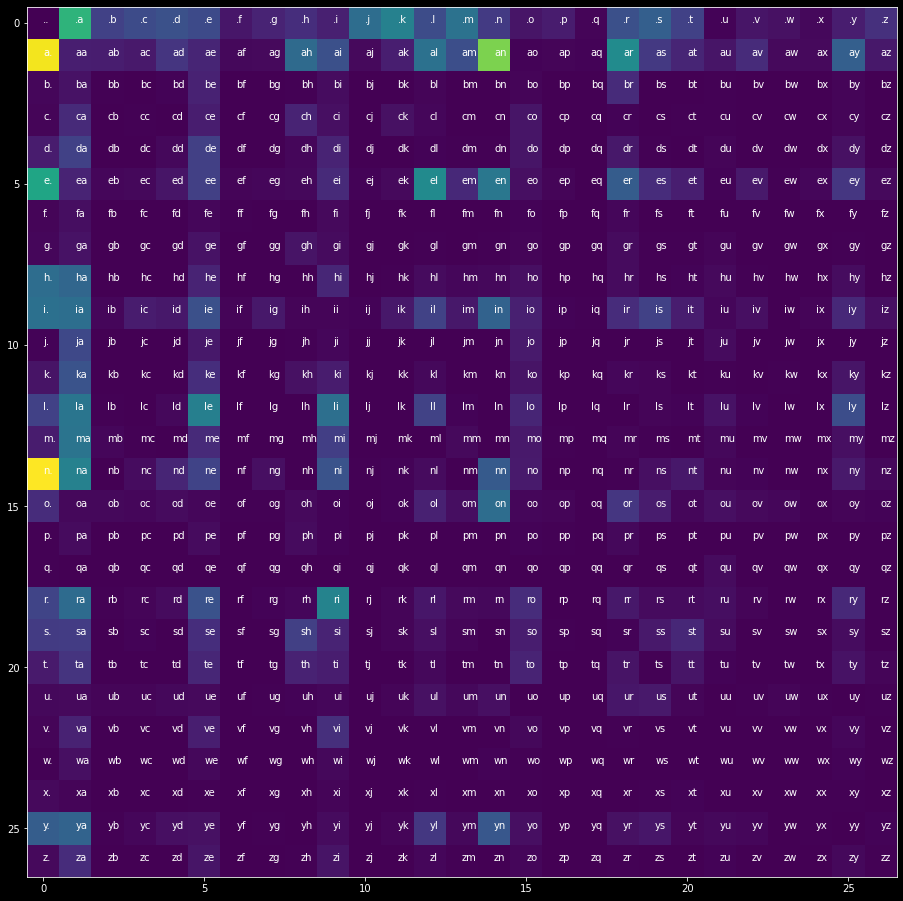

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N)
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        plt.text(j, i, itos[i] + itos[j])

## Sampling

Using the object `N` we would sample from the Bigram.

Sampler link:
https://pytorch.org/docs/stable/generated/torch.multinomial.html

Timecode:
https://youtu.be/PaCmpygFfXo?t=1657

In [13]:
g = torch.Generator().manual_seed(2144)

for i in range(20):
    ix = 0
    res = ""
    while True:
        p = N[ix].float()
        p /= p.sum()
        ix = int(torch.multinomial(p, 1, True, generator=g))
        if ix == 0:
            break
        res += itos[ix]
    print(res)

hinasha
deranchahiunaal
stttol
ckalimawim
menconana
kario
qugiantommoenceffynnni
rdgha
y
s
rastonridondan
a
ke
torokhema
k
sssa
rum
alio
sh
nnanon


## Doing some vector operations

timecode: https://youtu.be/PaCmpygFfXo?t=2467

In [14]:
P = N.float()

In [15]:
P.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [16]:
P /= P.sum(1, keepdim=True)

In [17]:
g = torch.Generator().manual_seed(2144)

for i in range(20):
    ix = 0
    res = ""
    while True:
        p = P[ix]
        ix = int(torch.multinomial(p, 1, True, generator=g))
        if ix == 0:
            break
        res += itos[ix]
    print(res)

hinasha
deranchahiunaal
stttol
ckalimawim
menconana
kario
qugiantommoenceffynnni
rdgha
y
s
rastonridondan
a
ke
torokhema
k
sssa
rum
alio
sh
nnanon


Place where stopped: https://youtu.be/PaCmpygFfXo?t=3020

## Loss function now

He is using log likelihood function for the loss.

Let's try to build the same kind of a neural net.

In [18]:
import torch.nn.functional as F

In [19]:
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [20]:
g = torch.Generator().manual_seed(2144)
W = torch.randn((len(stoi), len(stoi)), generator=g, requires_grad=True)

In [21]:
x_enc = F.one_hot(xs, num_classes=len(stoi)).float()
logits = x_enc @ W
counts = logits.exp()
softmax = counts / counts.sum(1, keepdims=True)

loss = -softmax[torch.arange(len(ys)), ys].log().mean() # I don't quite agree with such a loss func, but anyway
loss

tensor(3.5188, grad_fn=<NegBackward0>)

In [22]:
W.grad = None
loss.backward()